In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys, os, sys, math
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt, numpy as np
from jfi import jaxm
from jfi.experimental.jit import autojit, nestedautojit
import redis
import numpy as np

root_path = Path("").absolute().parent
if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))
from mpcjax import solve
from mpcjax.problem_struct import Problem
from tests.dynamics import f_fx_fu_fn

In [39]:
N, xdim, udim = 20, 4, 2

Q = np.tile(np.eye(xdim), (N, 1, 1))
R = np.tile(1e-2 * np.eye(udim), (N, 1, 1))
x0 = np.tile(np.ones(xdim), (1,))
X_ref, U_ref = np.zeros((N, xdim)), np.zeros((N, udim))
X_prev, U_prev = np.zeros((N, xdim)), np.zeros((N, udim))
u_lim = 1e0
u_l, u_u = -u_lim * np.ones((N, udim)), u_lim * np.ones((N, udim))

problem = dict(
    f_fx_fu_fn=f_fx_fu_fn,
    Q=Q,
    R=R,
    x0=x0,
    X_ref=X_ref,
    U_ref=U_ref,
    X_prev=X_prev,
    U_prev=U_prev,
    u_l=u_l,
    u_u=u_u,
    solver_settings=dict(smooth_alpha=1e2, solver="sqp", linesearch="scan", maxls=100),
    reg_x=1e0,
    reg_u=1e-1,
    max_it=10,
    res_tol=1e-12,
    verbose=True,
    #slew_rate=1e-2,
    P=1.0 * jaxm.ones((N,)),
    dtype=np.float32,
    device="cpu",
)

# develop matrix balancing routines

In [4]:
rconn = redis.Redis()
H = jaxm.frombuffer(rconn.get("H"), dtype=np.float32)
H = H.reshape((round(math.sqrt(H.size)),) * 2)

In [28]:
Pl = jaxm.diag(1.0 / jaxm.linalg.norm(H, axis=-1))
Pr = jaxm.diag(1.0 / jaxm.linalg.norm(Pl @ H, axis=-2))
g = jaxm.randn(H.shape[-1]).astype(np.float32)

In [33]:
print(f"{jaxm.linalg.cond(H):.4e}")
print(f"{jaxm.linalg.cond(Pl @ H):.4e}")
print(f"{jaxm.linalg.cond(Pl @ H @ Pr):.4e}")

1.0235e+12
5.4078e+07
1.8400e+04


In [46]:
xs = jaxm.linalg.solve(H.astype(jaxm.float64), g.astype(jaxm.float64))
x1 = jaxm.linalg.solve((Pl @ H).astype(jaxm.float64), (Pl @ g).astype(jaxm.float64))
x2 = jaxm.linalg.solve((Pl @ H).astype(jaxm.float32), (Pl @ g).astype(jaxm.float32))
x3 = jaxm.linalg.solve(H.astype(jaxm.float32),  g.astype(jaxm.float32))
x3 = jaxm.linalg.solve(H.astype(jaxm.float32),  g.astype(jaxm.float32))
x4 = Pr @ jaxm.linalg.solve((Pl @ H @ Pr).astype(jaxm.float64), (Pl @ g).astype(jaxm.float64))
x5 = Pr @ jaxm.linalg.solve((Pl @ H @ Pr).astype(jaxm.float32), (Pl @ g).astype(jaxm.float32))

In [47]:
x4

Array([ 1.43073701e-04, -7.15367677e-05, -2.98351698e+00, -2.06574653e-02,
        1.15311557e+01, -2.70816233e+01, -6.23125346e+00, -9.13589288e+00,
       -1.16367513e+01,  3.84911937e-01,  3.83432008e+00,  1.65608561e+01,
       -1.88264119e+00,  2.27686400e+01,  3.72778939e+01,  1.02663515e+01,
       -9.56152279e+00,  1.42311540e+01, -1.52317662e+01, -3.54431537e+00,
       -7.39688076e+00, -5.45252555e+00, -4.98109645e+00, -8.39461638e+00,
       -9.89049900e+00, -1.04511483e+01,  1.40375734e+01, -6.99482800e+00,
        5.47049405e+00, -3.20209808e+00, -1.44437717e+01,  3.74822280e+00,
        2.96059974e+01, -3.01954925e+00, -2.20307704e+00,  6.71717737e+00,
       -2.91466201e+01,  1.98967994e+01,  4.19558127e+00, -1.21700702e+01],      dtype=float64)

In [48]:
xs

Array([ 1.43072966e-04, -7.15364006e-05, -2.98351818e+00, -2.06500236e-02,
        1.15311182e+01, -2.70816252e+01, -6.23125180e+00, -9.13589433e+00,
       -1.16367320e+01,  3.84911403e-01,  3.83434112e+00,  1.65608505e+01,
       -1.88265626e+00,  2.27686397e+01,  3.72779021e+01,  1.02663513e+01,
       -9.56152855e+00,  1.42311514e+01, -1.52317635e+01, -3.54431478e+00,
       -7.39688057e+00, -5.45252555e+00, -4.98107645e+00, -8.39461224e+00,
       -9.89050383e+00, -1.04511500e+01,  1.40375717e+01, -6.99482623e+00,
        5.47050189e+00, -3.20209658e+00, -1.44437813e+01,  3.74822194e+00,
        2.96059969e+01, -3.01955030e+00, -2.20307941e+00,  6.71717691e+00,
       -2.91466209e+01,  1.98968008e+01,  4.19558103e+00, -1.21700699e+01],      dtype=float64)

In [49]:
jaxm.linalg.norm(P @ H, axis=-2)

Array([3.4176817e+00, 5.3216023e+00, 1.2287449e-04, 6.2042687e-05,
       1.1598365e-04, 6.1943356e-05, 1.0911996e-04, 6.1690225e-05,
       1.0229484e-04, 6.1282975e-05, 9.5521260e-05, 6.0720638e-05,
       8.8814064e-05, 6.0001741e-05, 8.2190301e-05, 5.9124533e-05,
       7.5669741e-05, 5.8087458e-05, 6.9275513e-05, 5.6889938e-05,
       6.3035259e-05, 5.5533837e-05, 5.6982997e-05, 5.4026361e-05,
       5.1162788e-05, 5.2385785e-05, 4.5636680e-05, 5.0653540e-05,
       4.0504470e-05, 4.8921193e-05, 3.5960562e-05, 4.7395461e-05,
       3.2484360e-05, 4.6570854e-05, 3.1583186e-05, 4.7753383e-05,
       3.9118338e-05, 5.5036959e-05, 8.7474677e-05, 8.7909226e-05],      dtype=float32)

In [50]:
print(f"{jaxm.linalg.norm(xs - x1) / jaxm.linalg.norm(xs):.4e}")
print(f"{jaxm.linalg.norm(xs - x2) / jaxm.linalg.norm(xs):.4e}")
print(f"{jaxm.linalg.norm(xs - x3) / jaxm.linalg.norm(xs):.4e}")
print(f"{jaxm.linalg.norm(xs - x4) / jaxm.linalg.norm(xs):.4e}")
print(f"{jaxm.linalg.norm(xs - x5) / jaxm.linalg.norm(xs):.4e}")

5.1948e-07
3.1252e-06
1.4192e-06
6.7272e-07
2.2781e-06


# solve

In [22]:
prob = Problem(xdim=xdim, udim=udim, N=N)
prob.f_fx_fu_fn = f_fx_fu_fn

In [55]:
from line_profiler import LineProfiler
LP = LineProfiler()
LP.add_function(solve)
LP.wrap_function(solve)(**problem, direct_solve=True)
#X, U, data = solve(**problem, direct_solve=True)
print(f"dtype = {X.dtype}, device = {X.device()}")
LP.print_stats(output_unit=1e-3)

+------+------------+------------+------------+----------+----------+----------+
|  it  |   elaps    |    obj     |   resid    |  reg_x   |  reg_u   |  alpha   |
+------+------------+------------+------------+----------+----------+----------+
| 0001 |  2.470e-02 |  2.935e-01 |  1.936e+00 |  1.0e+00 |  1.0e-01 |  1.0e+02 |
| 0002 |  4.890e-02 |  5.320e-02 |  1.502e-02 |  1.0e+00 |  1.0e-01 |  1.0e+02 |
| 0003 |  7.184e-02 |  5.319e-02 |  4.965e-03 |  1.0e+00 |  1.0e-01 |  1.0e+02 |
| 0004 |  9.785e-02 |  5.319e-02 |  2.652e-03 |  1.0e+00 |  1.0e-01 |  1.0e+02 |
| 0005 |  1.208e-01 |  5.319e-02 |  2.563e-03 |  1.0e+00 |  1.0e-01 |  1.0e+02 |
| 0006 |  1.464e-01 |  5.319e-02 |  1.608e-03 |  1.0e+00 |  1.0e-01 |  1.0e+02 |
| 0007 |  1.757e-01 |  5.319e-02 |  1.929e-04 |  1.0e+00 |  1.0e-01 |  1.0e+02 |
| 0008 |  2.019e-01 |  5.319e-02 |  1.528e-09 |  1.0e+00 |  1.0e-01 |  1.0e+02 |
| 0009 |  2.271e-01 |  5.319e-02 |  3.635e-04 |  1.0e+00 |  1.0e-01 |  1.0e+02 |
| 0010 |  2.503e-01 |  5.319

# Plot the results for a qualitative check

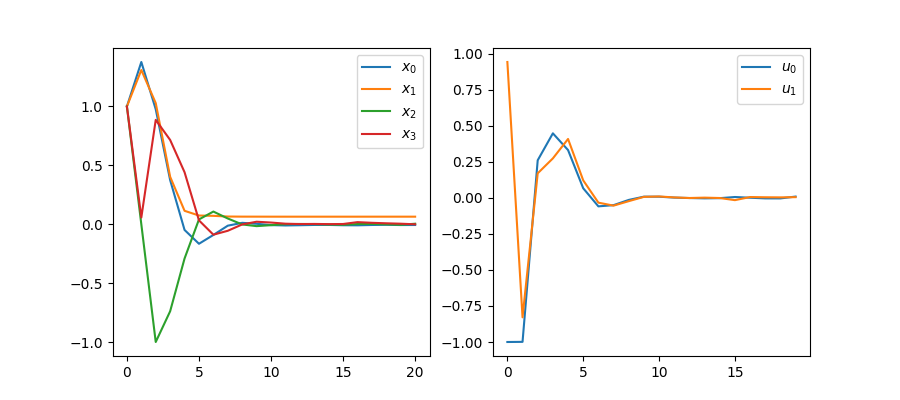

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
for i in range(X.shape[-1]):
    ax[0].plot(X[:, i], label=f"$x_{i}$")
ax[0].legend()
for i in range(U.shape[-1]):
    ax[1].plot(U[:, i], label=f"$u_{i}$")
ax[1].legend()

# Check optimality conditions

In [71]:
def solve(H, g, dtype=jaxm.float64):
    return jaxm.linalg.solve(*jaxm.to((H, g), dtype=dtype))

def solve_precond(H, g, L, R, dtype=jaxm.float64):
    H, g, L, r = jaxm.to((H, g, L, R), dtype=dtype)
    H = jaxm.diag(1.0 / L) @ H @ jaxm.diag(1.0 / R)
    g = g / L
    return jaxm.linalg.solve(H, g) / R

def cond(H):
    return jaxm.linalg.cond(jaxm.to(H, device="cpu", dtype=jaxm.float64))

In [74]:
H = jaxm.randn((100, 100))
g = jaxm.randn((100,))
Q = jaxm.linalg.qr(H)[0]
H = Q @ jaxm.diag(jaxm.logspace(-9, 0, Q.shape[-1])) @ Q.T

ys = solve(H, g)
L, R = jaxm.linalg.norm(H, axis=-1), jaxm.linalg.norm(H, axis=-2)
L2, R2 = jaxm.linalg.norm(H, axis=-2), jaxm.linalg.norm(H, axis=-1)

print(f"{jaxm.norm(ys - solve(H, g, jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, L, R, jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, L2, R2, jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, L, jaxm.ones(R.shape), jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, L2, jaxm.ones(R.shape), jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, jaxm.ones(R.shape), R, jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, jaxm.ones(R.shape), R2, jaxm.float32)) / jaxm.norm(ys):.4e}")

4.9932e+00
1.9298e+01
1.9298e+01
1.9298e+01
1.9298e+01
8.3982e-01
8.3982e-01


In [70]:
print(f"{cond(jaxm.diag(1.0 / L) @ H @ jaxm.diag(1.0 / R)):.4e}")
print(f"{cond(jaxm.diag(1.0 / L2) @ H @ jaxm.diag(1.0 / R2)):.4e}")
print(f"{cond(jaxm.diag(1.0 / L) @ H):.4e}")
print(f"{cond(jaxm.diag(1.0 / L2) @ H):.4e}")
print(f"{cond(H @ jaxm.diag(1.0 / R)):.4e}")
print(f"{cond(H @ jaxm.diag(1.0 / R2)):.4e}")
print(f"{cond(H):.4e}")

8.6951e+04
8.6951e+04
8.8527e+04
8.8527e+04
8.8527e+04
8.8527e+04
1.0000e+05
